In [1]:
!python classify_image.py --model_dir ./imagenet --image_file abhishek.jpg

I tensorflow/stream_executor/dso_loader.cc:108] successfully opened CUDA library libcublas.so locally
I tensorflow/stream_executor/dso_loader.cc:102] Couldn't open CUDA library libcudnn.so. LD_LIBRARY_PATH: 
I tensorflow/stream_executor/cuda/cuda_dnn.cc:2259] Unable to load cuDNN DSO
I tensorflow/stream_executor/dso_loader.cc:108] successfully opened CUDA library libcufft.so locally
I tensorflow/stream_executor/dso_loader.cc:108] successfully opened CUDA library libcuda.so.1 locally
I tensorflow/stream_executor/dso_loader.cc:108] successfully opened CUDA library libcurand.so locally
/usr/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)
I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I t

In [2]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the resulting frame
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [1]:
import numpy as np
import cv2

cap = cv2.VideoCapture('video.avi')

while(cap.isOpened()):
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf


FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_integer('num_top_predictions', 5,
                            """Display this many predictions.""")
def create_graph(model_dir):
    """Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile(os.path.join(
            model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')


class NodeLookup(object):
    """Converts integer node ID's to human readable labels."""
    def __init__(self, model_dir='',
                 label_lookup_path=None,
                 uid_lookup_path=None):
        if not label_lookup_path:
            label_lookup_path = os.path.join(
                model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
        if not uid_lookup_path:
            uid_lookup_path = os.path.join(
                model_dir, 'imagenet_synset_to_human_label_map.txt')
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
        
    def load(self, label_lookup_path, uid_lookup_path):
        """Loads a human readable English name for each softmax node.
        Args:
        uid_lookup_path: string UID to human-readable string.
        Returns:
        dict from integer node ID to human-readable string.    """
        if not tf.gfile.Exists(uid_lookup_path):
            tf.logging.fatal('File does not exist %s', uid_lookup_path)
        if not tf.gfile.Exists(label_lookup_path):
            tf.logging.fatal('File does not exist %s', label_lookup_path)
            
        # Loads mapping from string UID to human-readable string
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        p = re.compile(r'[n\d]*[ \S,]*')
        for line in proto_as_ascii_lines:
            parsed_items = p.findall(line)
            uid = parsed_items[0]
            human_string = parsed_items[2]
            uid_to_human[uid] = human_string

        # Loads mapping from string UID to integer node ID.
        node_id_to_uid = {}
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
                node_id_to_uid[target_class] = target_class_string[1:-2]
                
        # Loads the final mapping of integer node ID to human-readable string
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            if val not in uid_to_human:
                tf.logging.fatal('Failed to locate: %s', val)
            name = uid_to_human[val]
            node_id_to_name[key] = name
        return node_id_to_name
    
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

model_dir = "./imagenet"
create_graph(model_dir)

/usr/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


In [2]:

def run_inference_on_image(image_data):
    #if not tf.gfile.Exists(image):
    #    tf.logging.fatal('File does not exist %s', image)
    #image_data = tf.gfile.FastGFile(image, 'rb').read()
    #print(image_data[:100])
    
    with tf.Session() as sess:
        # Some useful tensors:
        # 'softmax:0': A tensor containing the normalized prediction across
        #   1000 labels.
        # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
        #   float description of the image.
        # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
        #   encoding of the image.
        # Runs the softmax tensor by feeding the image_data as input to the graph.
        softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
        predictions = sess.run(softmax_tensor,
                               {'DecodeJpeg:0': image_data})
        predictions = np.squeeze(predictions)
        # Creates node ID --> English string lookup.
        node_lookup = NodeLookup(model_dir=model_dir)
        
        top_k = predictions.argsort()[-FLAGS.num_top_predictions:][::-1]
        inference = []
        for node_id in top_k:
            human_string = node_lookup.id_to_string(node_id)
            score = predictions[node_id]
            inference.append('\n%s (score = %.5f)' % (human_string, score))
    return inference
            
#run_inference_on_image("abhishek.jpg")


In [3]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(cv2.__version__)

3.1.0


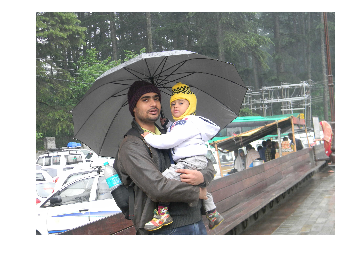

In [4]:
image_Data = cv2.imread('abhishek.jpg')
plt.axis("off")
plt.imshow(cv2.cvtColor(image_Data, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
print(run_inference_on_image(image_Data))

['\numbrella (score = 0.99218)', '\npier (score = 0.00022)', '\nstage (score = 0.00018)', '\nunicycle, monocycle (score = 0.00017)', '\ncellular telephone, cellular phone, cellphone, cell, mobile phone (score = 0.00017)']


In [12]:
import numpy as np
import cv2

cap = cv2.VideoCapture('video.avi')    
font = cv2.FONT_HERSHEY_SIMPLEX

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))

while(cap.isOpened()):
    for i in range(100):
        ret, frame = cap.read()
        
    

    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    inference = run_inference_on_image(frame)
    for i,j in enumerate(inference):
        cv2.putText(frame, j, (0,20+20*i), font, 0.5,(255,255,255),1,cv2.LINE_AA)
    
    out.write(frame)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()